In [25]:
#importing required packages

import numpy as np
import pandas as pd
import scipy as sp
import json
import re
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
import seaborn as sns
%matplotlib inline

In [2]:
#reading CellPhone Dataset
mobile_df = pd.read_json('Cell_Phones_and_Accessories_5.json', lines=True)
mobile_df.to_csv('Cell_Phones_and_Accessories_5.csv', sep=',', index=False)

In [3]:
#adding new columns "helpfulnessnum" and "helpfulnessden" to the dataframe

mobile_df[['HelpfulnessNum','HelpfulnessDen']] = pd.DataFrame(mobile_df.helpful.values.tolist(), index = mobile_df.index)


In [4]:
#eliminating duplicate data
mobile_df.drop_duplicates(subset=['reviewerID', 'asin','unixReviewTime'],inplace=True)
mobile_df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,HelpfulnessNum,HelpfulnessDen
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014",0,0
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014",0,0
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014",0,0
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013",4,4
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013",2,3
5,APX47D16JOP7H,120401325X,RLH,"[1, 2]",These make using the home button easy. My daug...,3,Cute,1381536000,"10 12, 2013",1,2
6,A1JVVYYO7G56DS,120401325X,Tyler Evans,"[0, 0]",Came just as described.. It doesn't come unstu...,5,best thing ever..,1377129600,"08 22, 2013",0,0
7,A6FGO4TBZ3QFZ,3998899561,Abdullah Albyati,"[1, 2]",it worked for the first week then it only char...,1,not a good Idea,1384992000,"11 21, 2013",1,2
8,A2JWEDW5FSVB0F,3998899561,Adam,"[2, 3]","Good case, solid build. Protects phone all aro...",5,Solid Case,1380067200,"09 25, 2013",2,3
9,A8AJS1DW7L3JJ,3998899561,Agata Majchrzak,"[1, 1]",This is a fantastic case. Very stylish and pro...,5,Perfect Case,1396483200,"04 3, 2014",1,1


In [5]:
#Adding helpful and upvote %ages for metrics
mobile_df['Helpful %'] = np.where(mobile_df['HelpfulnessDen'] > 0, mobile_df['HelpfulnessNum'] / mobile_df['HelpfulnessDen'], -1)
mobile_df['% Upvote'] = pd.cut(mobile_df['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
mobile_df['Id'] = mobile_df.index;
mobile_df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,HelpfulnessNum,HelpfulnessDen,Helpful %,% Upvote,Id
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014",0,0,-1.000000,Empty,0
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014",0,0,-1.000000,Empty,1
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014",0,0,-1.000000,Empty,2
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013",4,4,1.000000,80-100%,3
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013",2,3,0.666667,60-80%,4
5,APX47D16JOP7H,120401325X,RLH,"[1, 2]",These make using the home button easy. My daug...,3,Cute,1381536000,"10 12, 2013",1,2,0.500000,40-60%,5
6,A1JVVYYO7G56DS,120401325X,Tyler Evans,"[0, 0]",Came just as described.. It doesn't come unstu...,5,best thing ever..,1377129600,"08 22, 2013",0,0,-1.000000,Empty,6
7,A6FGO4TBZ3QFZ,3998899561,Abdullah Albyati,"[1, 2]",it worked for the first week then it only char...,1,not a good Idea,1384992000,"11 21, 2013",1,2,0.500000,40-60%,7
8,A2JWEDW5FSVB0F,3998899561,Adam,"[2, 3]","Good case, solid build. Protects phone all aro...",5,Solid Case,1380067200,"09 25, 2013",2,3,0.666667,60-80%,8
9,A8AJS1DW7L3JJ,3998899561,Agata Majchrzak,"[1, 1]",This is a fantastic case. Very stylish and pro...,5,Perfect Case,1396483200,"04 3, 2014",1,1,1.000000,80-100%,9


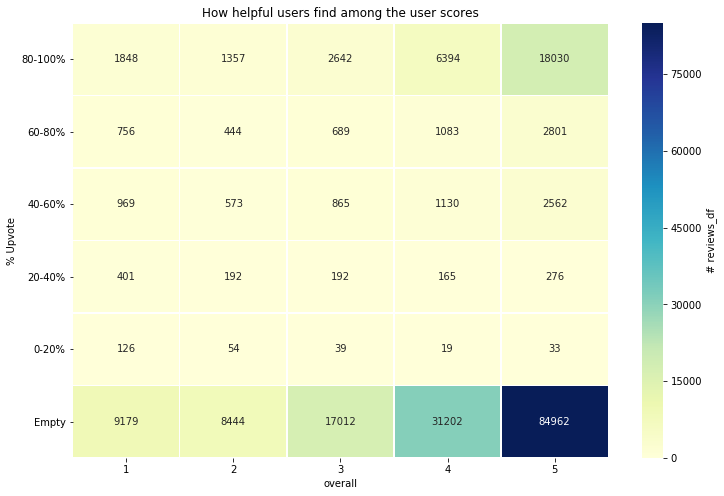

In [33]:
#Creating heat map of overall ratings vs reviews
df_m = mobile_df.groupby(['overall', '% Upvote']).agg({'Id': 'count'})
df_m = df_m.unstack()
df_m.columns = df_m.columns.get_level_values(1)

fig = plt.figure(figsize=(12,8))
sns.heatmap(df_m[df_m.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews_df'})
plt.yticks(rotation=0)
plt.title('How helpful users find among the user scores')
plt.show()

In [9]:
#Cleaning Data using regex

regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
   reviewText = reviewText.lower()
   reviewText = regEx.sub(' ', reviewText).strip()
   return reviewText
mobile_df["summaryClean"] = mobile_df["summary"].apply(cleanReviews)
mobile_df["cleanreviewText"] = mobile_df["reviewText"].apply(cleanReviews)

In [10]:
df =  mobile_df[mobile_df['overall'] != 3]
X = df['cleanreviewText']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['overall'].map(y_dict)

In [11]:
model = CountVectorizer(stop_words = 'english')
model.fit_transform(X)

<173000x70327 sparse matrix of type '<class 'numpy.int64'>'
	with 5554703 stored elements in Compressed Sparse Row format>

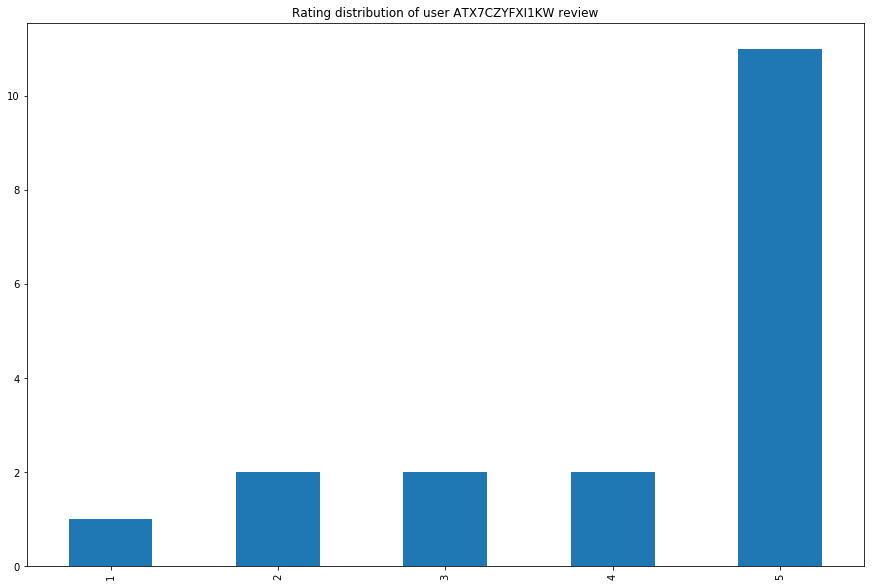

In [34]:
def plot_user(reviewerID):
   df_1user = mobile_df[mobile_df['reviewerID'] == reviewerID]['overall']
   df_1user_plot = df_1user.value_counts(sort=False)
   ax = df_1user_plot.plot(kind = 'bar', figsize = (15,10), title = 'Rating distribution of user {} review'.format(mobile_df[mobile_df['reviewerID'] == reviewerID]['reviewerID'].iloc[0]))
   plt.show()
#A3KEZLJ59C1JVH
plot_user('ATX7CZYFXI1KW')

In [22]:
#calculating the accuracy scores for k=1-15
mean_acc = np.zeros((15))
std_acc = np.zeros((15))

for i in range(1,16):
    
    knn = KNeighborsClassifier(n_neighbors = i)
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X.shape[0]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(f1_score(y_test, y_pred))
    knn_model_1 = knn.fit(X_train, y_train)
    print(i)
    mean_acc[i-1] = metrics.accuracy_score(y_test, y_pred)
    std_acc[i-1]=np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])

    print('k-NN accuracy for test set: %f' % knn_model_1.score(X_test, y_test))
    print('===============================================================')
mean_acc

# features: 173000
# train records: 129750
# test records: 43250
0.9073163031753966
1
k-NN accuracy for test set: 0.837087
# features: 173000
# train records: 129750
# test records: 43250
0.8838496636202952
2
k-NN accuracy for test set: 0.804000
# features: 173000
# train records: 129750
# test records: 43250
0.9242847263133628
3
k-NN accuracy for test set: 0.863306
# features: 173000
# train records: 129750
# test records: 43250
0.9162802241584261
4
k-NN accuracy for test set: 0.851815
# features: 173000
# train records: 129750
# test records: 43250
0.92693222127573
5
k-NN accuracy for test set: 0.867121
# features: 173000
# train records: 129750
# test records: 43250
0.9247364235692482
6
k-NN accuracy for test set: 0.864324
# features: 173000
# train records: 129750
# test records: 43250
0.9288694464814019
7
k-NN accuracy for test set: 0.869919
# features: 173000
# train records: 129750
# test records: 43250
0.9280439286667599
8
k-NN accuracy for test set: 0.869110
# features: 173000

array([0.83708671, 0.804     , 0.86330636, 0.85181503, 0.86712139,
       0.8643237 , 0.86991908, 0.86910983, 0.87045087, 0.8700578 ,
       0.8699422 , 0.8699422 , 0.86906358, 0.86945665, 0.86855491])

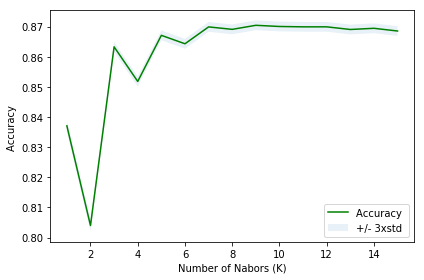

In [23]:
#plotting the accuracy scores for all values of K
plt.plot(range(1,16),mean_acc,'g')
plt.fill_between(range(1,16),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()